In [25]:

import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, RepeatedKFold, LeaveOneOut
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_predict
import numpy as np, seaborn as sns, matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os
import sys
from scipy.stats import linregress

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.insert(0, project_root)

from src.config import Config
import src.eda as eda
import src.present_value as present_value
from src.ml_utils import remove_outliers, calculate_metrics, analysis_plots, create_scatter_plot_with_regression

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# REUSABLE FUNCTIONS FOR BRIDGE AND STRUCTURES DATA ANALYSIS

def prepare_data(df_vp, target_name, exclude_codes=None, contamination=0.1):
    """
    Prepare and clean bridge data for a specific target variable.
    """
    # Select relevant columns
    df = df_vp.loc[:, 'CÓDIGO':'ALCANCE'].join(df_vp.loc[:, [target_name]])
    
    # Group by project code
    puentes_cols = ['PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2', 'PUENTES PEATONALES UND']
    df_grouped = df.groupby('CÓDIGO').agg({
        'ALCANCE': 'first',
        'PUENTES VEHICULARES UND': 'sum',
        'PUENTES VEHICULARES M2': 'sum',
        'PUENTES PEATONALES UND': 'sum',
        target_name: 'sum'
    }).reset_index()
    
    # Filter: projects with bridges and positive target values
    df_filtered = df_grouped[
        (df_grouped[puentes_cols].sum(axis=1) > 0) & 
        (df_grouped[target_name] > 0)
    ]
    
    # Exclude specific codes if provided
    if exclude_codes:
        df_filtered = df_filtered[~df_filtered['CÓDIGO'].isin(exclude_codes)]
    
    # Remove outliers
    df_clean = remove_outliers(df_filtered, target_name, contamination=contamination)
    
    return df_filtered, df_clean


def train_linear_regression_with_loo(X, y, use_log_transform=False, model_name=None):
    """
    Train linear regression model using Leave-One-Out cross-validation.
    """
    # Ensure X is 2D
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    
    # Remove zeros if using log transform
    if use_log_transform:
        mask_nonzero = (X.flatten() > 0) & (y > 0)
        X = X[mask_nonzero]
        y = y[mask_nonzero]
    
    # Initialize Leave-One-Out
    loo = LeaveOneOut()
    
    # Create model
    if use_log_transform:
        model = TransformedTargetRegressor(
            regressor=Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ]),
            func=np.log,
            inverse_func=np.exp
        )
    else:
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    
    # LOO Cross-validation
    y_pred = np.zeros_like(y)
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred[test_idx] = model.predict(X_test)
    
    # Calculate metrics
    if model_name is None:
        model_name = "Log Transform" if use_log_transform else "No Transform"
    
    metrics = calculate_metrics(y, y_pred, model_name)
    
    # Fit final model on all data
    model.fit(X, y)
    
    return {
        'predictions': y_pred,
        'metrics': metrics,
        'model': model,
        'X': X,
        'y': y
    }


def run_complete_analysis(df_vp, target_name, predictor_name, 
                          exclude_codes=None, use_log_transform=False):
    """
    Run complete analysis pipeline: prepare data, visualize, train model, and evaluate.
    """
    print("=" * 90)
    print(f"ANALYSIS: {predictor_name} → {target_name}")
    if use_log_transform:
        print("(with Log Transformation)")
    print("=" * 90)
    
    # 1. Prepare data
    df_filtered, df_clean = prepare_data(df_vp, target_name, exclude_codes)
    print(f"\nDataset size: {len(df_clean)} samples")
    
    # 2. Create scatter plot with regression (with interactive tooltips)
    print("\n📊 Creating scatter plot with regression line...")
    create_scatter_plot_with_regression(
        df_filtered, 
        predictor_name, 
        target_name,
        df_raw=None,  # No df_raw for bridge analysis
        title=f'{predictor_name} vs {target_name} by ALCANCE'
    )
    
    # 3. Train model and get predictions
    print(f"\n🤖 Training {'log-transformed ' if use_log_transform else ''}linear regression model...")
    X = df_clean[predictor_name].values
    y = df_clean[target_name].values
    
    results = train_linear_regression_with_loo(
        X, y, 
        use_log_transform=use_log_transform,
        model_name=f"{target_name} {'(Log)' if use_log_transform else ''}"
    )
    
    # 4. Display metrics
    metrics = results['metrics']
    print(f"\n📈 Model Performance:")
    print(f"  R²:         {metrics['R²']:.4f}")
    print(f"  RMSE:       {metrics['RMSE']:,.2f}")
    print(f"  MAPE:       {metrics['MAPE (%)']:.2f}%")
    print(f"  Median AE:  {metrics.get('Median AE', 0):,.2f}")
    
    # 5. Create actual vs predicted plot
    print("\n📊 Creating actual vs predicted plot...")
    
    # If log transform was used, filter df_clean to match the filtered data
    df_for_plot = df_clean.copy()
    if use_log_transform and len(results['y']) < len(df_clean):
        # Filter to remove zeros (same logic as in train_linear_regression_with_loo)
        mask_nonzero = (df_clean[predictor_name] > 0) & (df_clean[target_name] > 0)
        df_for_plot = df_clean[mask_nonzero].copy()
    
    # Use centralized analysis_plots from ml_utils
    analysis_plots(
        results['y'], 
        results['predictions'],
        df_for_plot,
        predictor_name,
        target_name,
        hue_name='ALCANCE',
        df_raw=None  # No df_raw available in bridge analysis
    )
    
    print("\n" + "=" * 90)
    
    return {
        'df_filtered': df_filtered,
        'df_clean': df_clean,
        'model_results': results,
        'metrics': metrics
    }


In [30]:
## EXTRACT DATA FROM DATABASE
pv = present_value.PresentValue()
anual_increment = pv.fetch_incremento_from_database()

fase = "III"
preproccesing = eda.EDA()
df_raw = preproccesing.assemble_projects_from_database(fase)
df_vp = preproccesing.create_dataset(pv.present_value_costs, fase=fase)

c:\Code\Road-Project-Prediction\src\eda.py:292: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



ANALYSIS: PUENTES VEHICULARES M2 → 4 - SUELOS
(with Log Transformation)
  → Warning: Only 7 samples. Skipping outlier detection.

Dataset size: 7 samples

📊 Creating scatter plot with regression line...


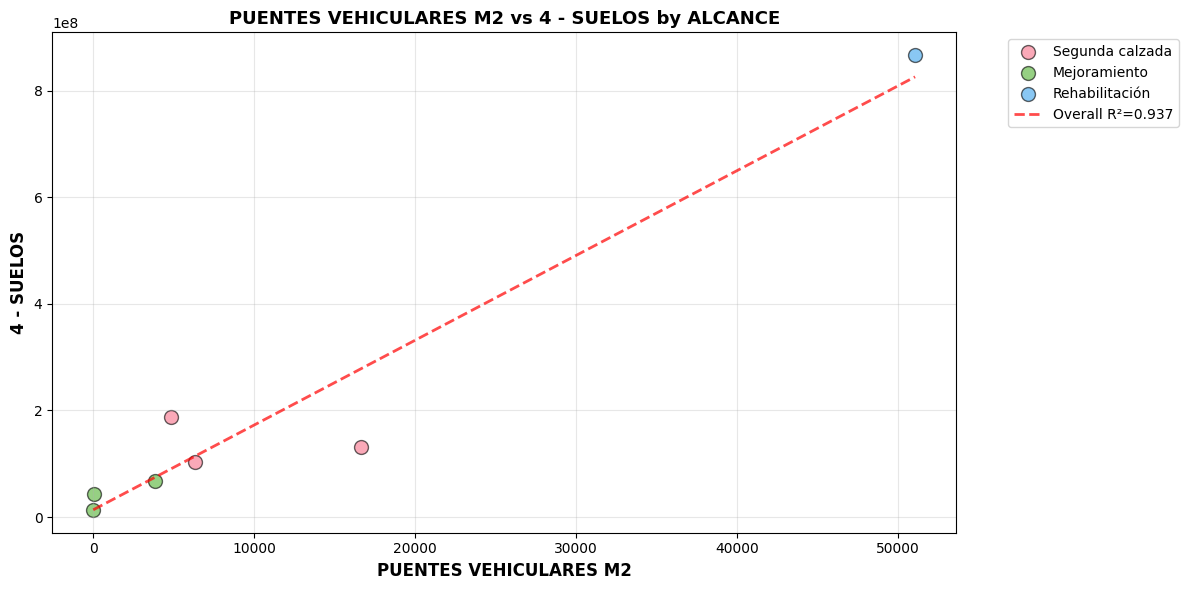


🤖 Training log-transformed linear regression model...

📈 Model Performance:
  R²:         0.9307
  RMSE:       75,610,324.78
  MAPE:       39.00%
  Median AE:  35,176,572.00

📊 Creating actual vs predicted plot...


In [ ]:
# ANALYSIS 1: PUENTES VEHICULARES M2 → 4 - SUELOS (with Log Transformation)

results_suelos = run_complete_analysis(
    df_vp=df_vp,
    target_name='4 - SUELOS',
    predictor_name='PUENTES VEHICULARES M2',
    exclude_codes=['0654801'],
    use_log_transform=True  # Using log transformation for better fit
)

In [ ]:
# ANALYSIS 2: PUENTES VEHICULARES UND → 8 - ESTRUCTURAS (without Log Transformation)

results_estructuras = run_complete_analysis(
    df_vp=df_vp,
    target_name='8 - ESTRUCTURAS',
    predictor_name='PUENTES VEHICULARES UND',
    exclude_codes=['0654801'],
    use_log_transform=False  # No log transformation (better performance for this case)
)

ANALYSIS: PUENTES VEHICULARES UND → 8 - ESTRUCTURAS
  → Warning: Only 6 samples. Skipping outlier detection.

Dataset size: 6 samples

📊 Creating scatter plot with regression line...



🤖 Training linear regression model...

📈 Model Performance:
  R²:         0.9221
  RMSE:       122,215,456.09
  MAPE:       2897.90%
  Median AE:  110,770,940.94

📊 Creating actual vs predicted plot...
